In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import json
import io
from AutoClusterHPO import AutoClusterHPO
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.float_format', '{:.2f}'.format)

# Leitura de Dados

In [2]:
df_profiles = pd.read_json(r'..\data\raw\profile_data.json')
df_posts = pd.read_json(r'..\data\raw\post_data.json')

# Gerar Dataframes com Quantitativas de Perfis
cols_int = df_profiles.columns[df_profiles.dtypes == 'int64']
cols = ['username'] + cols_int.tolist()
df_profiles_int = df_profiles[cols].copy()

# Gerar Dataframes com Quantitativas de Posts
cols_int = df_posts.columns[df_posts.dtypes == 'int64']
cols = ['ownerUsername', 'timestamp'] + cols_int.tolist()
df_posts_int = df_posts[cols].copy()

# Limpeza e Tratamento de Dados

Converter 'timestamp' p\ Data

In [3]:
df_posts_int['data_hora'] = pd.to_datetime(df_posts_int['timestamp'])

Agrupar Posts + Reels por 'ownerId' e 'ownerUsername'

In [4]:
df_posts_int_gruped = df_posts_int.groupby(['ownerId', 'ownerUsername']).agg(
    commentsSum=('commentsCount', 'sum'),
    likesSum=('likesCount', 'sum'),
    minData=('data_hora', 'min'),
    maxData=('data_hora', 'max'),
    count=('ownerId', 'count')
).reset_index()

df_posts_int_gruped.head()

,ownerId,ownerUsername,commentsSum,likesSum,minData,maxData,count
0,7999637,claudiocastrorj,19225,92799,2025-05-30 12:49:56+00:00,2025-06-13 14:03:13+00:00,30
1,18449431,nubialima,18,351,2025-06-11 20:29:03+00:00,2025-06-11 20:29:03+00:00,1
2,23552759,virginiamendesoficial,316,1545,2025-06-01 12:00:00+00:00,2025-06-12 11:30:00+00:00,3
3,38151300,valdetario,334,990,2025-05-27 15:07:35+00:00,2025-05-27 15:07:35+00:00,1
4,44117761,danibarbalho,166,2372,2025-06-12 11:07:03+00:00,2025-06-12 11:07:03+00:00,1


Calcular '% ENGAJAMENTO', 'RECENCIA' e 'FREQUENCIA'

In [5]:
df_profiles_posts_int = pd.merge(df_profiles_int, df_posts_int_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1) 
df_profiles_posts_int['TOTAL ENGAJAMENTO'] = (df_profiles_posts_int['commentsSum'] + df_profiles_posts_int['likesSum'])
df_profiles_posts_int[r'% ENGAJAMENTO'] =  df_profiles_posts_int['TOTAL ENGAJAMENTO'] / df_profiles_posts_int['followersCount']
df_profiles_posts_int['RECENCIA'] = 1 / ((df_profiles_posts_int['maxData'].max() - df_profiles_posts_int['maxData']).dt.days + 1)
df_profiles_posts_int['FREQUENCIA'] = df_profiles_posts_int['count'] / ((df_profiles_posts_int['maxData'] - df_profiles_posts_int['minData']).dt.days + 1)
 

df_profiles_posts_int.head()

,username,id,followersCount,followsCount,highlightReelCount,igtvVideoCount,postsCount,fbid,ownerUsername,commentsSum,likesSum,minData,maxData,count,TOTAL ENGAJAMENTO,% ENGAJAMENTO,RECENCIA,FREQUENCIA
0,jeronimorodriguesba,12547733711,692137,3737,19,145,5246,17841412651338466,jeronimorodriguesba,3705,55140,2025-06-09 14:49:06+00:00,2025-06-14 01:04:19+00:00,30,58845,0.09,1.00,6.00
1,ibaneisoficial,8354690711,192018,3043,3,77,3301,17841408241354336,ibaneisoficial,18573,32693,2025-01-06 19:06:46+00:00,2025-06-13 13:29:00+00:00,29,51266,0.27,1.00,0.18
2,clecioluis_,214942370,159441,6121,7,428,6660,17841400911103358,clecioluis_,9188,55032,2025-06-05 16:56:03+00:00,2025-06-14 00:31:19+00:00,29,64220,0.40,1.00,3.22
3,ronaldocaiado,578026968,1373629,2814,10,439,10122,17841401289049032,ronaldocaiado,27323,419719,2024-08-14 15:37:54+00:00,2025-06-13 22:03:29+00:00,25,447042,0.33,1.00,0.08
4,gladsoncameli,1523264831,173518,6802,6,353,8851,17841400024953800,gladsoncameli,1781,36328,2025-05-27 02:44:55+00:00,2025-06-13 00:51:04+00:00,29,38109,0.22,0.50,1.71


In [6]:
df_profiles_posts_int.columns

Index(['username', 'id', 'followersCount', 'followsCount',
       'highlightReelCount', 'igtvVideoCount', 'postsCount', 'fbid',
       'ownerUsername', 'commentsSum', 'likesSum', 'minData', 'maxData',
       'count', 'TOTAL ENGAJAMENTO', '% ENGAJAMENTO', 'RECENCIA',
       'FREQUENCIA'],
      dtype='object')

# Análise de Perfil dos Concorrentes

Cor alterada com Sucesso!


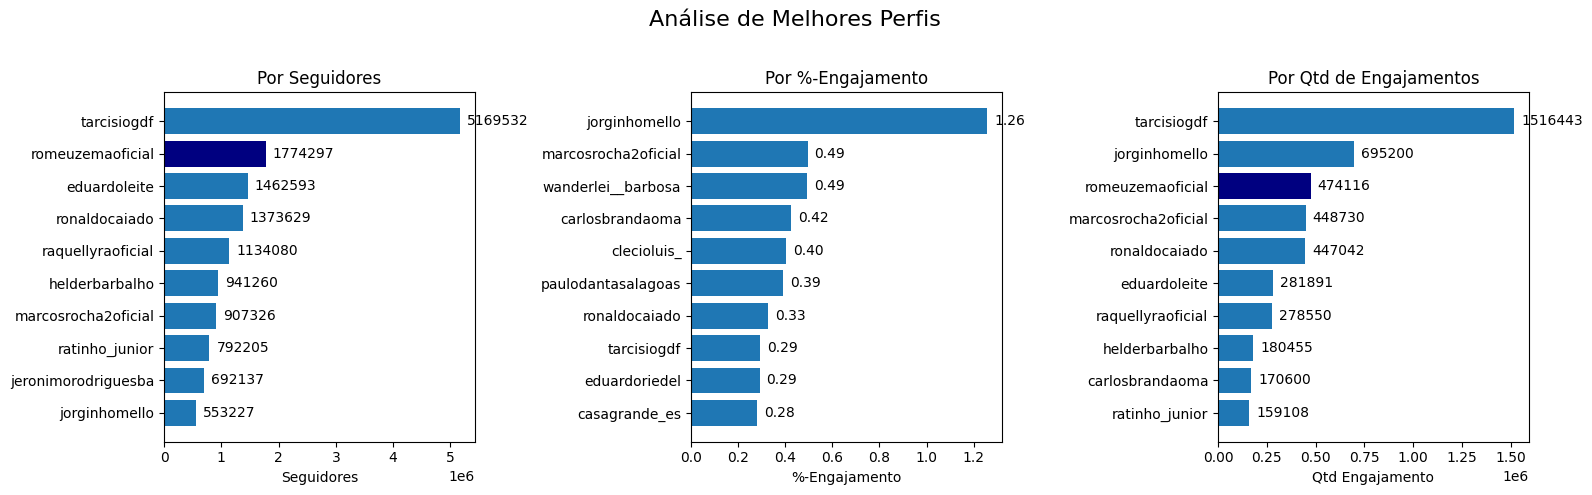

Figura 'graficos_de_barras_destacados.png' gerada com sucesso.


In [85]:
def plotarFigura1(client_name):
    
    def plotarBarraSeguidores(client_name):
        
        # Calcular Estatísticas
        top_10_followers = df_profiles_posts_int.groupby('username')['followersCount'].sum().sort_values(ascending=True).tail(10).reset_index()
        
        # --- 4. Configuração do Primeiro Gráfico (Superior) ---
        # Preparar cores e rótulos para o primeiro gráfico
        cores1 = ['#1f77b4'] * 10 # Cor padrão para as barras
        try:
            # Encontra a posição (índice) do elemento X nos dados ordenados
            indice_x = top_10_followers.loc[top_10_followers['username'] == client_name].index[0]
            cores1[indice_x] = '#000080' # Cor de destaque para o elemento X
            print('Cor alterada com Sucesso!')
        except KeyError:
            indice_x = -1 # Trata o caso do elemento não ser encontrado

        # Plota o gráfico de barras
        barras1 = ax1.barh(top_10_followers['username'], top_10_followers['followersCount'], color=cores1)
        ax1.bar_label(barras1, fmt='%d', padding=5)
        ax1.set_title(f'Por Seguidores')
        ax1.set_xlabel('Seguidores')

    def plotarBarraPercEngajamento(client_name):

        # Calcular Estatísticas
        top_10_followers = df_profiles_posts_int.groupby('username')[r'% ENGAJAMENTO'].max().sort_values(ascending=True).tail(10).reset_index()

        # --- 5. Configuração do Segundo Gráfico (Inferior) ---
        # Preparar cores e rótulos para o segundo gráfico
        cores2 = ['#1f77b4'] * len(top_10_followers) # Cor padrão para as barras
        try:
            # Encontra a posição (índice) do elemento Y nos dados ordenados
            indice_y = top_10_followers.loc[top_10_followers['username'] == client_name].index[0]
            cores2[indice_y] = '#000080' # Cor de destaque para o elemento Y
        except KeyError:
            indice_y = -1 # Trata o caso do elemento não ser encontrado
        except IndexError:
            pass

        # Plota o gráfico de barras
        barras2 = ax2.barh(top_10_followers['username'], top_10_followers[r'% ENGAJAMENTO'], color=cores2)
        ax2.bar_label(barras2, fmt='%.2f', padding=5)
        ax2.set_title(f'Por %-Engajamento')
        ax2.set_xlabel('%-Engajamento')
    
    def plotarBarraQtdEngajamento(client_name):

        # Calcular Estatísticas
        top_10_followers = df_profiles_posts_int.groupby('username')['TOTAL ENGAJAMENTO'].max().sort_values(ascending=True).tail(10).reset_index()
        
        # --- 5. Configuração do Segundo Gráfico (Inferior) ---
        # Preparar cores e rótulos para o segundo gráfico
        cores2 = ['#1f77b4'] * len(top_10_followers) # Cor padrão para as barras
        try:
            # Encontra a posição (índice) do elemento Y nos dados ordenados
            indice_y = top_10_followers.loc[top_10_followers['username'] == client_name].index[0]
            cores2[indice_y] = '#000080' # Cor de destaque para o elemento Y
        except KeyError:
            indice_y = -1 # Trata o caso do elemento não ser encontrado
        except IndexError:
            pass

        # Plota o gráfico de barras
        barras3 = ax3.barh(top_10_followers['username'], top_10_followers['TOTAL ENGAJAMENTO'], color=cores2)
        ax3.bar_label(barras3, fmt='%d', padding=5)
        ax3.set_title(f'Por Qtd de Engajamentos')
        ax3.set_xlabel('Qtd Engajamento')
    
    # --- 3. Criação da Figura e dos Gráficos (Subplots) ---
    # Cria a figura com 2 linhas e 1 coluna de gráficos
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Análise de Melhores Perfis', fontsize=16)
      
    plotarBarraSeguidores(client_name)
    plotarBarraPercEngajamento(client_name)
    plotarBarraQtdEngajamento(client_name)

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # Para exibir a figura diretamente (se estiver em um ambiente interativo como Jupyter)
    plt.show()

    print("Figura 'graficos_de_barras_destacados.png' gerada com sucesso.")

plotarFigura1('romeuzemaoficial')

Cor alterada com Sucesso!


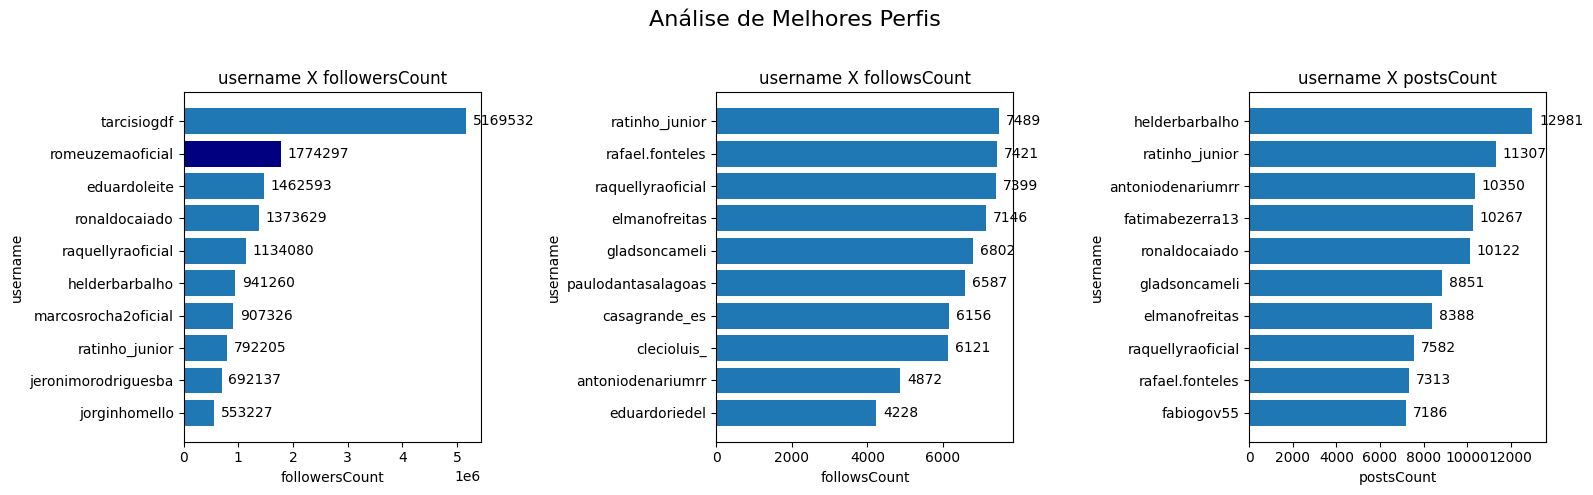

Figura 'graficos_de_barras_destacados.png' gerada com sucesso.


(<_io.BytesIO at 0x196321d6a70>,
 {'followers':               username  followersCount
  0        jorginhomello          553227
  1  jeronimorodriguesba          692137
  2       ratinho_junior          792205
  3  marcosrocha2oficial          907326
  4       helderbarbalho          941260
  5    raquellyraoficial         1134080
  6        ronaldocaiado         1373629
  7         eduardoleite         1462593
  8     romeuzemaoficial         1774297
  9          tarcisiogdf         5169532,
  'follows':              username  followsCount
  0       eduardoriedel          4228
  1   antoniodenariumrr          4872
  2         clecioluis_          6121
  3       casagrande_es          6156
  4  paulodantasalagoas          6587
  5       gladsoncameli          6802
  6       elmanofreitas          7146
  7   raquellyraoficial          7399
  8     rafael.fonteles          7421
  9      ratinho_junior          7489,
  'posts_count':             username  postsCount
  0         fabiogov55

In [86]:
def plotarFigura1(client_name):
    
    """ 

    def tratarDados():
    
        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        df_profiles_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        df_profiles_posts_int['TOTAL ENGAJAMENTO'] = (df_profiles_posts_int['commentsSum'] + df_profiles_posts_int['likesSum'])
        df_profiles_posts_int[r'% ENGAJAMENTO'] =  df_profiles_posts_int['TOTAL ENGAJAMENTO'] / df_profiles_posts_int['followersCount']
        df_profiles_posts_int['RECENCIA'] = 1 / ((df_profiles_posts_int['maxData'].max() - df_profiles_posts_int['maxData']).dt.days + 1)
        df_profiles_posts_int['FREQUENCIA'] = df_profiles_posts_int['count'] / ((df_profiles_posts_int['maxData'] - df_profiles_posts_int['minData']).dt.days + 1)

        return df_profiles_posts_int
        
    df_profiles_posts_int = tratarDados()
    
    """   
    
    def plotarBarraMax(client_name, x_col, y_col, ax1):
        
        # Calcular Estatísticas
        top_10 = df_profiles_posts_int.groupby([y_col])[x_col].max().sort_values(ascending=True).tail(10).reset_index()
        
        # --- 4. Configuração do Primeiro Gráfico (Superior) ---
        # Preparar cores e rótulos para o primeiro gráfico
        cores1 = ['#1f77b4'] * 10 # Cor padrão para as barras
        
        if client_name in list(top_10['username']):
            try:
                # Encontra a posição (índice) do elemento X nos dados ordenados
                indice_x = top_10.loc[top_10[y_col] == client_name].index[0]
                cores1[indice_x] = '#000080' # Cor de destaque para o elemento X
                print('Cor alterada com Sucesso!')
            except KeyError:
                indice_x = -1 # Trata o caso do elemento não ser encontrado

        # Plota o gráfico de barras
        barras1 = ax1.barh(top_10[y_col], top_10[x_col], color=cores1)
        ax1.bar_label(barras1, fmt='%d', padding=5)
        ax1.set_title(f'{y_col} X {x_col}')
        ax1.set_xlabel(x_col)
        ax1.set_ylabel(y_col)

        return top_10

    # --- 3. Criação da Figura e dos Gráficos (Subplots) ---
    # Cria a figura com 2 linhas e 1 coluna de gráficos
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Análise de Melhores Perfis', fontsize=16)
      
    top_10_followers = plotarBarraMax(client_name, 'followersCount', 'username', ax1)
    top_10_follows = plotarBarraMax(client_name, 'followsCount', 'username', ax2)
    top_10_posts_count = plotarBarraMax(client_name, 'postsCount', 'username', ax3)

    dataframes = {
                    "followers": top_10_followers,
                    "follows": top_10_follows,
                    "posts_count": top_10_posts_count
    }

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # Para exibir a figura diretamente (se estiver em um ambiente interativo como Jupyter)
    plt.show()

    print("Figura 'graficos_de_barras_destacados.png' gerada com sucesso.")

    return buffer, dataframes

plotarFigura1('romeuzemaoficial')

In [87]:
top_10_followers = top_10_followers = df_profiles_posts_int.groupby('username')['followersCount'].sum().sort_values(ascending=True).tail(10).reset_index()

--- Dados Originais (Formato Longo) ---
    Ano    Produto  Vendas
0  2024  Produto A     100
1  2024  Produto B     150
2  2024  Produto C     120
3  2025  Produto A     110
4  2025  Produto B     180
5  2025  Produto C     130

--- Dados Pivotados (Prontos para Plotar) ---
Produto  Produto A  Produto B  Produto C
Ano                                     
2024           100        150        120
2025           110        180        130


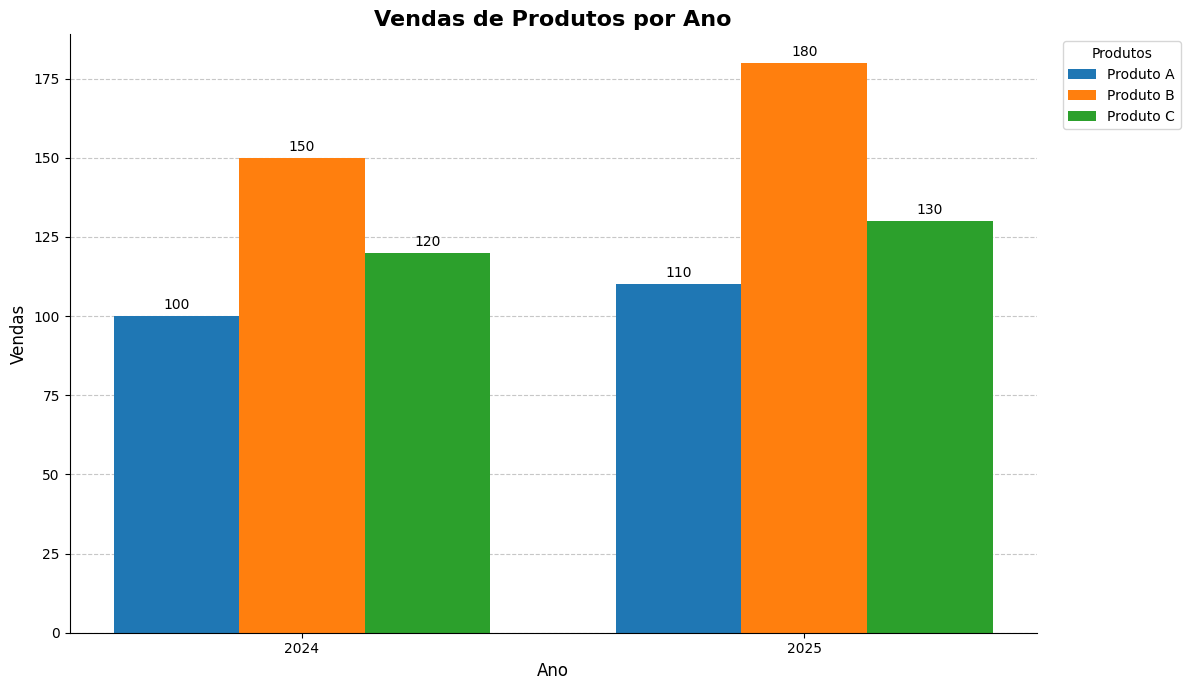

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Criar dados de exemplo em formato "longo"
# Este é o formato comum, com uma coluna para cada categoria e uma para o valor.
data = {
    'Ano': ['2024', '2024', '2024', '2025', '2025', '2025'],
    'Produto': ['Produto A', 'Produto B', 'Produto C', 'Produto A', 'Produto B', 'Produto C'],
    'Vendas': [100, 150, 120, 110, 180, 130]
}
df = pd.DataFrame(data)

print("--- Dados Originais (Formato Longo) ---")
print(df)

# 2. Pivotar os dados para o formato "largo" usando pandas
# O segredo está aqui: transformamos as subcategorias (Produto) em colunas.
# - index: se torna a categoria principal no eixo X.
# - columns: os valores desta coluna se tornam as novas colunas de dados.
# - values: os valores que preencherão a tabela.
dados_pivot = df.pivot(index='Ano', columns='Produto', values='Vendas')

print("\n--- Dados Pivotados (Prontos para Plotar) ---")
print(dados_pivot)

# 3. Preparar as variáveis para a plotagem
# Categorias principais (ex: '2024', '2025')
categorias_principais = dados_pivot.index
# Subcategorias (ex: 'Produto A', 'Produto B', 'Produto C')
subcategorias = dados_pivot.columns

n_categorias_principais = len(categorias_principais)
n_subcategorias = len(subcategorias)

# Gera as posições dos grupos principais no eixo X (ex: [0, 1])
x = np.arange(n_categorias_principais)
# Define a largura de cada barra. Deve ser pequena o suficiente para que todas caibam no grupo.
largura_barra = 0.25

# 4. Criar a figura e os eixos do gráfico
fig, ax = plt.subplots(figsize=(12, 7))

# 5. Loop para criar as barras para cada subcategoria (cada produto)
for i, produto in enumerate(subcategorias):
    # Cálculo da posição de cada barra dentro do grupo.
    # O cálculo desloca cada conjunto de barras em relação ao centro do grupo (x).
    # O objetivo é centralizar o cluster de barras em torno do tick do eixo X.
    posicao = x - (largura_barra * n_subcategorias / 2) + (i * largura_barra) + (largura_barra / 2)
    
    # Pega os valores para o produto atual
    valores = dados_pivot[produto]
    
    # Cria as barras
    barra = ax.bar(posicao, valores, largura_barra, label=produto)

    # Adiciona os rótulos de valor no topo de cada barra para clareza
    ax.bar_label(barra, padding=3, fmt='%d') # fmt='%d' para mostrar como inteiro


# 6. Adicionar rótulos, título, legenda e outros detalhes de formatação
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Vendas', fontsize=12)
ax.set_title('Vendas de Produtos por Ano', fontsize=16, fontweight='bold')

# Posiciona os rótulos da categoria principal (Anos) no centro dos grupos de barras
ax.set_xticks(x)
ax.set_xticklabels(categorias_principais)

# Adiciona a legenda para identificar as cores das barras
ax.legend(title='Produtos', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adiciona uma grade horizontal para facilitar a leitura dos valores
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True) # Coloca a grade atrás das barras

# Remove as bordas superior e direita para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajusta o layout para garantir que nada (como a legenda) seja cortado
fig.tight_layout()

# 7. Exibir o gráfico
plt.show()

In [89]:
def filtro(usernames):
    return (df_posts['ownerUsername'] == usernames[0]) | (df_posts['ownerUsername'] == usernames[1]) | (df_posts['ownerUsername'] == usernames[2])

filtro = filtro(['tarcisiogdf', 'romeuzemaoficial', 'eduardoleite'])

df_posts_top_3 = df_posts[filtro]

df_posts_top_3_grouped = pd.merge(df_posts_top_3, df_profiles_int, how='left', left_on='ownerUsername', right_on='username')

df_posts_top_3_grouped.groupby(['ownerUsername', 'type']).agg(
    countType=('type', 'count'),
    followersMax=('followersCount', 'max')
)

countType  followersMax
ownerUsername    type                            
eduardoleite     Image            1       1462593
                 Sidecar          4       1462593
                 Video           24       1462593
romeuzemaoficial Image            7       1774297
                 Sidecar          5       1774297
                 Video           16       1774297
tarcisiogdf      Image            3       5169532
                 Sidecar          2       5169532
                 Video           25       5169532

# Clusterizações

In [ ]:
df_cluster, df_original, df, model, config, score, algo_name = clusterizar(df_cluster, df_original, pairplot=False)
plotarFiguraNColsPCA(df_original, df_cluster)

In [14]:
def plotarFigura2():
    
    def tratarDados():
        
        # LINHA CRÍTICA A SER ADICIONADA:
        # Carregue o arquivo JSON para um DataFrame
        posts_df = pd.read_json("data/raw/post_data.json")

        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        df_profiles_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        df_profiles_posts_int['TOTAL ENGAJAMENTO'] = (df_profiles_posts_int['commentsSum'] + df_profiles_posts_int['likesSum'])
        df_profiles_posts_int[r'% ENGAJAMENTO'] =  df_profiles_posts_int['TOTAL ENGAJAMENTO'] / df_profiles_posts_int['followersCount']
        df_profiles_posts_int['RECENCIA'] = 1 / ((df_profiles_posts_int['maxData'].max() - df_profiles_posts_int['maxData']).dt.days + 1)
        df_profiles_posts_int['FREQUENCIA'] = df_profiles_posts_int['count'] / ((df_profiles_posts_int['maxData'] - df_profiles_posts_int['minData']).dt.days + 1)
        
        return df_profiles_posts_int
    
    def plotarFiguraNColsPCA(df_original, df_cluster):
            
        def plotarDispersao():
            
            cluster_columns = [column for column in df_cluster.columns if column != 'Clusters (AutoClusterHPO)']
            
            # Redução de dimensionalidade com PCA
            pca = PCA(n_components=2)
            df_pca = pca.fit_transform(df_original[cluster_columns])
            df_original_copy['pca_x'] = df_pca[:, 0]
            df_original_copy['pca_y'] = df_pca[:, 1]
                
            # Visualização dos clusters com PCA
            axes_gs_principal = fig.add_subplot(gs_principal[0])
            plt.figure(figsize=(10, 7))
            sns.scatterplot(data=df_original_copy, x='pca_x', y='pca_y', hue='Clusters (AutoClusterHPO)', palette='deep', s=100, ax=axes_gs_principal) 
            axes_gs_principal.set_title(f" X ".join(cluster_columns))
            axes_gs_principal.set_xlabel('Componente Principal 1')
            axes_gs_principal.set_ylabel('Componente Principal 2')
            axes_gs_principal.grid(True)

            return df_original_copy[['pca_x', 'pca_y', 'Clusters (AutoClusterHPO)']]
        
        def plotarBarras():
            
            df_original['Clusters (AutoClusterHPO)'] = 'Cluster ' + df_original['Clusters (AutoClusterHPO)'].astype(str)
                
            media_1 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[0])].mean().reset_index().sort_values(by=str(df_cluster.columns[0]), ascending=True)
            media_2 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[1])].mean().reset_index().sort_values(by=str(df_cluster.columns[1]), ascending=True)
            media_3 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[2])].mean().reset_index().sort_values(by=str(df_cluster.columns[2]), ascending=True)
                
                
            # Plotar Gráfico de Barra 1
            axes_gs_0 = fig.add_subplot(gs[0])
            axes_gs_0.set_title(f'Clusters X {str(df_cluster.columns[0])}')
            barras1 = axes_gs_0.barh(media_1['Clusters (AutoClusterHPO)'], media_1[str(df_cluster.columns[0])])
            axes_gs_0.bar_label(barras1, fmt='%d', padding=-45)
            axes_gs_0.set_xticklabels([])
            axes_gs_0.set_xlabel(f'Média de {str(df_cluster.columns[0])}')

            # Plotar Gráfico de Barra 2
            axes_gs_1 = fig.add_subplot(gs[1])
            axes_gs_1.set_title(f'Clusters X {str(df_cluster.columns[1])}')
            barras2 = axes_gs_1.barh(media_2['Clusters (AutoClusterHPO)'], media_2[str(df_cluster.columns[1])])
            axes_gs_1.bar_label(barras2, fmt='%d', padding=5)
            axes_gs_1.set_xticklabels([])
            axes_gs_1.set_xlabel(f'Média de {str(df_cluster.columns[1])}')
                
            # Plotar Gráfico de Barra 3
            axes_gs1_0 = fig.add_subplot(gs1[0])
            axes_gs1_0.set_title(f'Clusters X {str(df_cluster.columns[2])}')
            barras3 = axes_gs1_0.barh(media_3['Clusters (AutoClusterHPO)'], media_3[str(df_cluster.columns[2])])
            axes_gs1_0.bar_label(barras3, fmt='%d', padding=-30)
            axes_gs1_0.set_xticklabels([])
            axes_gs1_0.set_xlabel(f'Média de {str(df_cluster.columns[2])}')

            return media_1, media_2, media_3
    
        # Copiar df original
        df_original_copy = df_original.copy()
            
        fig = plt.figure(figsize=(20, 7))
        gs_principal = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[2, 1, 1], wspace=0.2)
        gs = gs_principal[1].subgridspec(2, 1, hspace=0.4)
        gs1 = gs_principal[2].subgridspec(2, 1, hspace=0.4)
                
        fig.suptitle(
            f'Resultados da Clusterização entre: {str(df_cluster.columns[1])} X {str(df_cluster.columns[0])} X {str(df_cluster.columns[2])}',   # O texto do título
            fontsize=20,                    # Define o tamanho da fonte para 20
            fontweight='medium',
            y=1.03               # Define o estilo da fonte como negrito
        )
            
        df_original_copy = plotarDispersao()
        media_1, media_2, media_3 = plotarBarras()

        dataframes = {'df_original_copy' : df_original_copy, 
                    'df_media_1' : media_1,
                    'df_media_2' : media_2,
                    'df_media_3' : media_3}

        # --- 6. Finalização e Exibição/Salvamento da Figura ---
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

        buffer = io.BytesIO() 
        
        # Para salvar a figura em um arquivo
        plt.savefig(buffer, format='png', dpi=300)
        
        plt.show()

        return buffer, dataframes

    def clusterizar(df_cluster, df_original, pairplot=False):
        
        # Inicializar e aplicar o AutoCluster
        autocluster_tool = AutoClusterHPO(max_evals_per_algo=100) 
        df_original['Clusters (AutoClusterHPO)'], model, config, score, algo_name = autocluster_tool.fit_predict(df_cluster)
        
        # Passo 1: Guarde os nomes das colunas e o índice original
        original_columns = df_cluster.columns
        original_index = df_cluster.index
        
        # Passo 2: Escalar Dataframe
        scaler = StandardScaler()
        df_scaled_array = scaler.fit_transform(df_cluster)
        
        # Passo 3: Guadar valor novamente
        df_cluster = pd.DataFrame(df_scaled_array, index=original_index, columns=original_columns)
        df_cluster['Clusters (AutoClusterHPO)'] = df_original['Clusters (AutoClusterHPO)']
        
        stats_melted = pd.melt(df_original, id_vars=['Clusters (AutoClusterHPO)'], value_vars=df_cluster.columns, var_name='Variable', value_name='Value')
        df = stats_melted.groupby(['Clusters (AutoClusterHPO)', 'Variable']).describe().reset_index()

        return df_cluster, df_original, df, model, config, score, algo_name

    df_profiles_posts_int = tratarDados()
    
    df_original = df_profiles_posts_int
    df_cluster = df_profiles_posts_int[['followersCount', 'followsCount', 'postsCount']].copy()

    df_cluster, df_original, df, model, config, score, algo_name = clusterizar(df_cluster, df_original, pairplot=False)
    buffer, dataframes = plotarFiguraNColsPCA(df_original, df_cluster)

    return buffer, dataframes

Iniciando otimização de hiperparâmetros...
100%|██████████| 100/100 [00:00<00:00, 225.22trial/s, best loss: -0.44414421855542563]

Processo de AutoCluster concluído.
Melhor algoritmo: DBSCAN
Melhores parâmetros: {'eps': 0.5050887052680685, 'min_samples': 3}
Melhor pontuação CVI combinada: 0.6061


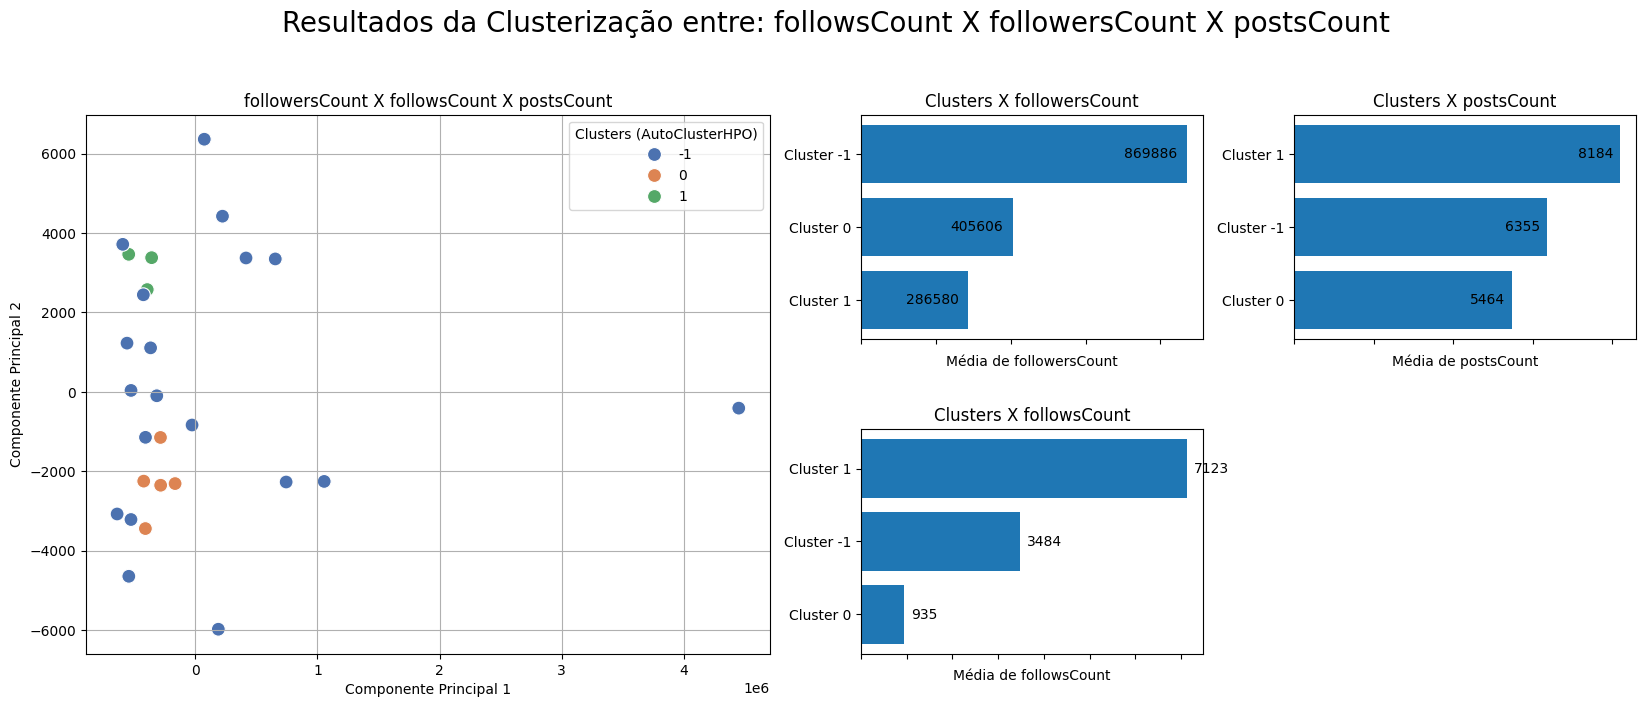

<Figure size 1000x700 with 0 Axes>

ValueError: could not convert string to float: 'Cluster -1'

<Figure size 2000x700 with 0 Axes>

In [99]:
def plotarFiguraNColsPCA(df_original, df_cluster):
        
    def plotarDispersao():
        
        # Redução de dimensionalidade com PCA
        pca = PCA(n_components=2)
        df_pca = pca.fit_transform(df_original[list(df_cluster.columns)])
        df_original_copy['pca_x'] = df_pca[:, 0]
        df_original_copy['pca_y'] = df_pca[:, 1]
            
        # Visualização dos clusters com PCA
        axes_gs_principal = fig.add_subplot(gs_principal[0])
        plt.figure(figsize=(10, 7))
        sns.scatterplot(data=df_original_copy, x='pca_x', y='pca_y', hue='Clusters (AutoClusterHPO)', palette='deep', s=100, ax=axes_gs_principal) 
        axes_gs_principal.set_title(f" X ".join([column for column in df_cluster.columns if column != 'Clusters (AutoClusterHPO)']))
        axes_gs_principal.set_xlabel('Componente Principal 1')
        axes_gs_principal.set_ylabel('Componente Principal 2')
        axes_gs_principal.grid(True)
    
    def plotarBarras():
        
        df_original['Clusters (AutoClusterHPO)'] = 'Cluster ' + df_original['Clusters (AutoClusterHPO)'].astype(str)
            
        media_1 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[0])].mean().reset_index().sort_values(by=str(df_cluster.columns[0]), ascending=True)
        media_2 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[1])].mean().reset_index().sort_values(by=str(df_cluster.columns[1]), ascending=True)
        media_3 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[2])].mean().reset_index().sort_values(by=str(df_cluster.columns[2]), ascending=True)
            
            
        # Plotar Gráfico de Barra 1
        axes_gs_0 = fig.add_subplot(gs[0])
        axes_gs_0.set_title(f'Clusters X {str(df_cluster.columns[0])}')
        barras1 = axes_gs_0.barh(media_1['Clusters (AutoClusterHPO)'], media_1[str(df_cluster.columns[0])])
        axes_gs_0.bar_label(barras1, fmt='%d', padding=-45)
        axes_gs_0.set_xticklabels([])
        axes_gs_0.set_xlabel(f'Média de {str(df_cluster.columns[0])}')

        # Plotar Gráfico de Barra 2
        axes_gs_1 = fig.add_subplot(gs[1])
        axes_gs_1.set_title(f'Clusters X {str(df_cluster.columns[1])}')
        barras2 = axes_gs_1.barh(media_2['Clusters (AutoClusterHPO)'], media_2[str(df_cluster.columns[1])])
        axes_gs_1.bar_label(barras2, fmt='%d', padding=5)
        axes_gs_1.set_xticklabels([])
        axes_gs_1.set_xlabel(f'Média de {str(df_cluster.columns[1])}')
            
        # Plotar Gráfico de Barra 3
        axes_gs1_0 = fig.add_subplot(gs1[0])
        axes_gs1_0.set_title(f'Clusters X {str(df_cluster.columns[2])}')
        barras3 = axes_gs1_0.barh(media_3['Clusters (AutoClusterHPO)'], media_3[str(df_cluster.columns[2])])
        axes_gs1_0.bar_label(barras3, fmt='%d', padding=-30)
        axes_gs1_0.set_xticklabels([])
        axes_gs1_0.set_xlabel(f'Média de {str(df_cluster.columns[2])}')
  
    # Copiar df original
    df_original_copy = df_original.copy()
        
    fig = plt.figure(figsize=(20, 7))
    gs_principal = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[2, 1, 1], wspace=0.2)
    gs = gs_principal[1].subgridspec(2, 1, hspace=0.4)
    gs1 = gs_principal[2].subgridspec(2, 1, hspace=0.4)
              
    fig.suptitle(
        f'Resultados da Clusterização entre: {str(df_cluster.columns[1])} X {str(df_cluster.columns[0])} X {str(df_cluster.columns[2])}',   # O texto do título
        fontsize=20,                    # Define o tamanho da fonte para 20
        fontweight='medium',
        y=1.03               # Define o estilo da fonte como negrito
    )
        
    plotarDispersao()
    plotarBarras()

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)
    
    plt.show()

    return buffer

df_original = df_profiles_posts_int
df_cluster = df_profiles_posts_int[['followersCount', 'followsCount', 'postsCount']].copy()

df_cluster, df_original, df, model, config, score, algo_name = clusterizar(df_cluster, df_original, pairplot=False)
plotarFiguraNColsPCA(df_original, df_cluster)

Iniciando otimização de hiperparâmetros...
100%|██████████| 100/100 [00:00<00:00, 236.78trial/s, best loss: -0.44414421855542563]

Processo de AutoCluster concluído.
Melhor algoritmo: DBSCAN
Melhores parâmetros: {'eps': 0.5050887052680685, 'min_samples': 3}
Melhor pontuação CVI combinada: 0.6061


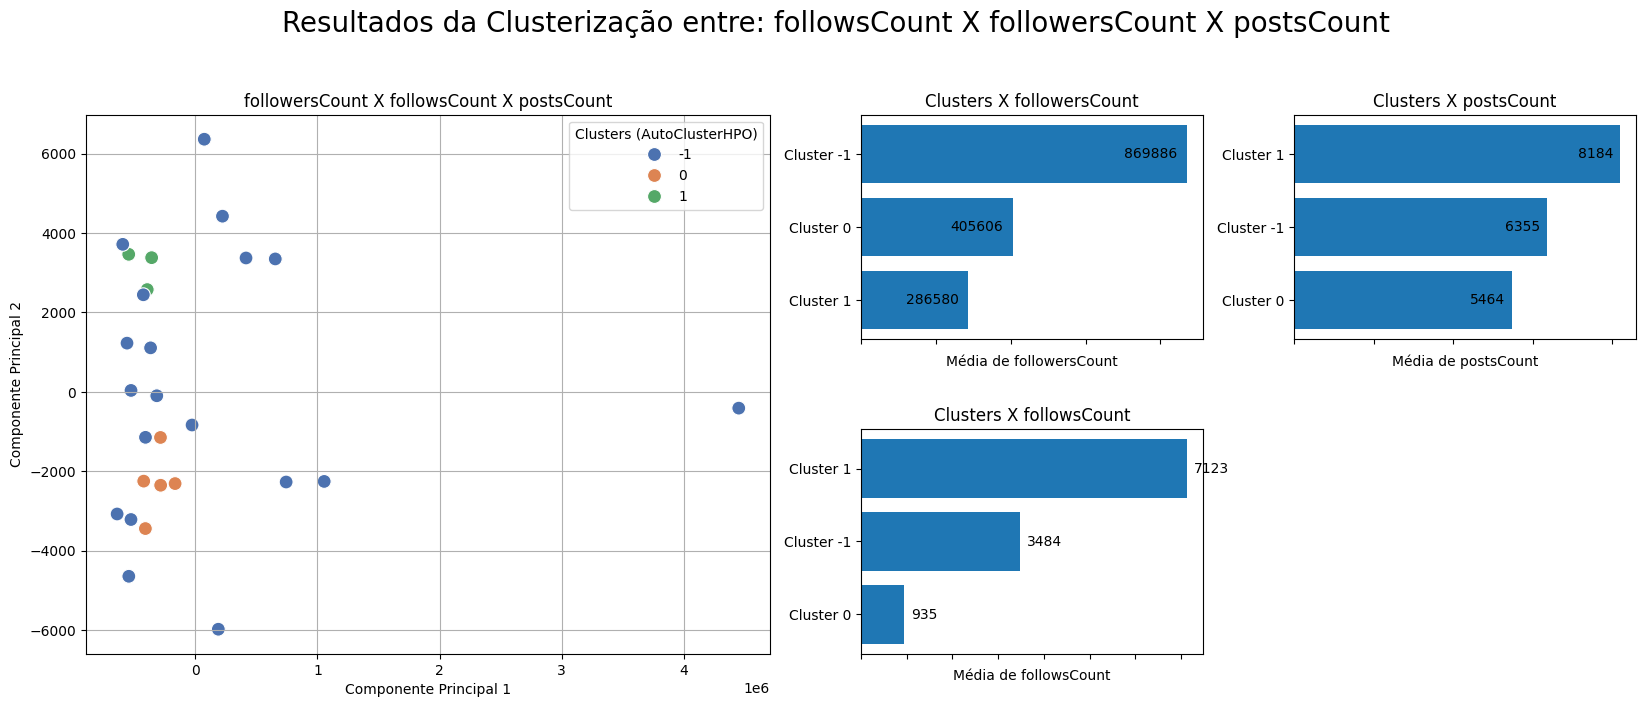

<Figure size 1000x700 with 0 Axes>

Clusters (AutoClusterHPO)        Variable Value                       \
                                            count      mean        std   
0                Cluster -1  followersCount 19.00 869886.95 1160547.04   
1                Cluster -1    followsCount 19.00   3484.95    2357.43   
2                Cluster -1      postsCount 19.00   6355.32    3367.50   
3                 Cluster 0  followersCount  5.00 405606.20  105500.30   
4                 Cluster 0    followsCount  5.00    935.40     499.57   
5                 Cluster 0      postsCount  5.00   5464.00     989.96   
6                 Cluster 1  followersCount  3.00 286580.67   99572.75   
7                 Cluster 1    followsCount  3.00   7123.00     310.14   
8                 Cluster 1      postsCount  3.00   8184.00     789.03   

                                                       
        min       25%       50%        75%        max  
0  78366.00 192121.00 403348.00 1037670.00 5169532.00  
1    248.00   1699.50   2899.00    5496.50    7489.00  
2   1164.00   3661.00   6339.00    8852.00   12981.00  
3 296294.00 310012.00 433499.00  434999.00  553227.00  
4    450.00    670.00    716.00    1126.00    1715.00  
5   4369.00   4859.00   5264.00    5909.00    6919.00  
6 173518.00 249268.50 325019.00  343112.00  361205.00  
7   6802.00   6974.00   7146.00    7283.50    7421.00  
8   7313.00   7850.50   8388.00    8619.50    8851.00

In [ ]:
df_original = df_profiles_posts_int
df_cluster = df_profiles_posts_int[['followersCount', 'followsCount', 'postsCount']].copy()
df_cluster, df_original, df, model, config, score, algo_name = clusterizar(df_cluster, df_original)
df